## Introduction

We will be using the **ALBERT** transformer model to predict sentiment from financial news.

ALBERT, a lite version of BERT, is a self-supervised learning model of language representation. It was considered a major breakthrough due to its similar performance to BERT but with significant parameter reduction.

The dataset was extracted from the following research article: [Malo, P., Sinha, A., Takala, P., Korhonen, P., & Wallenius, J. (2013, July 23). Good debt or bad debt: Detecting semantic orientations in economic texts. arXiv.org. Retrieved February 28, 2023, from https://arxiv.org/abs/1307.5336](https://arxiv.org/pdf/1307.5336.pdf)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import transformers
from transformers import BertTokenizer, BertForSequenceClassification

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

pd.set_option('display.max_colwidth', None)
%matplotlib inline

## Load Data

In [2]:
import codecs

# Open the input file for reading with the original encoding
with codecs.open('Sentences_AllAgree.txt', 'r', encoding='ISO-8859-1') as f:
    # Read the file content
    file_content = f.read()

# Open the output file for writing with utf-8 encoding
with codecs.open('Sentences_AllAgree_new.txt', 'w', encoding='utf-8') as f:
    # Write the file content with utf-8 encoding
    f.write(file_content)
    
# Load the new UTF-8 encoded file into a Pandas Dataframe
df = pd.read_csv('Sentences_AllAgree_new.txt', delimiter='\t')
display(df.head(5))

,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
0,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive"
1,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .@positive"
2,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .@positive
3,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .@positive"
4,"Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .@positive"


## Clean Data

As seen above, the data needs to be preprocessed before proceeding with analysis. Currently, the first row is placed in the columns section of the dataframe; we will shift this input one cell below with the following manipulation. 

In addition, we will separate each string at the `"@"` character using the .split() method. We can then separate the results into two columns named `news headline` and `sentiment`.

In [3]:
# Set column value to new row
new_row = list(df.columns)

# Insert the new row above the first row
df.loc[-1] = new_row
df.index = df.index + 1
df = df.sort_index()
display(df.head())

,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
1,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive"
2,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .@positive"
3,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .@positive
4,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .@positive"


In [4]:
# Look through each row and split at "@" character
df.columns = ['article']
news_article= []
sentiment = []

for index, row in df.iterrows():
    row = row['article'].split('@')
    news_article.append(row[0])
    sentiment.append(row[1])
    
# Create new dataframe
df = pd.DataFrame({"News Article": news_article, "Sentiment": sentiment})
display(df.head())

,News Article,Sentiment
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",neutral
1,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",positive
2,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",positive
3,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,positive
4,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .",positive


## Explore Data

**Distribution of word and character count**

First, we will remove all punctuations in each sentence using a combination of regex and string methods. The word length for each sentence will be appended to a list called `word_count` and the same for each character to `character_count`. 

In [5]:
import re

# Loop through each row and find word/character count
word_count = []
character_count = []

for i in range(len(df['News Article'])):
    # Remove any punctuations
    sentence = re.sub(r'[^\w\s]', '', df['News Article'][i])
    
    # Split sentence into list of words
    words = sentence.split()
    extracted_words = []
    
    # Iterate through each word to see if it is alphabetic
    for word in words:
        if word.isalpha():
            extracted_words.append(word)
    
    # Join list of extracted words together and append character count to list
    extracted_sentence = ' '.join(extracted_words)
    character_count.append(len(extracted_sentence))
    
    # Split extracted sentence into separate words and append word count to list
    split_sentence = extracted_sentence.split()
    word_count.append(len(split_sentence))

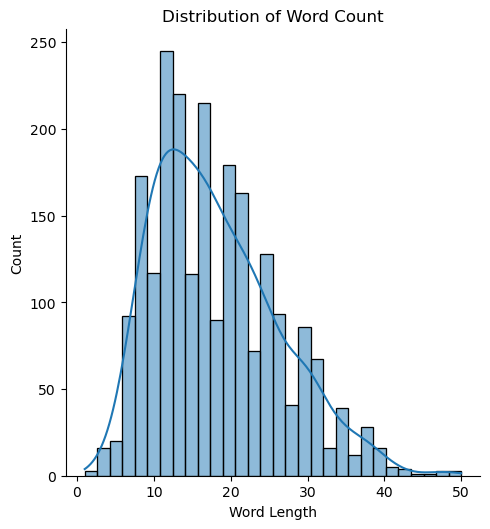

In [6]:
# Plot distribution of word count
sns.displot(word_count, kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Length')
plt.show()

The word count distribution appears to be normally distributed with the highest frequencies around 15-20 words. 

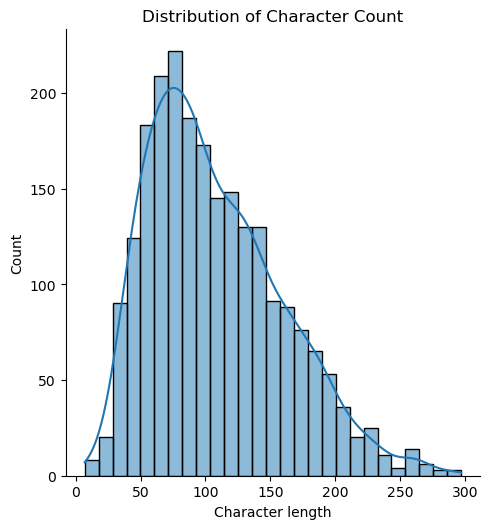

In [7]:
# Plot distribution of character count
sns.displot(character_count, kde=True)
plt.title('Distribution of Character Count')
plt.xlabel('Character length')
plt.show()

Similarly, the distribution of character length appears to be normally distributed with the highest frequencies around 60-100 characters. 

**Distribution of sentiment**

[]

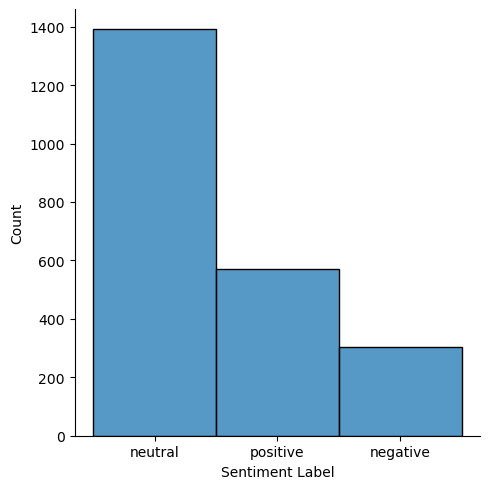

In [8]:
# Plot distribution of sentiment labels
sns.displot(df['Sentiment'], kind='hist')
plt.xlabel('Sentiment Label')
plt.plot()

Most of news articles provided in the dataset were `neutral` labels. From first glance, the data is considered imbalance so we may need to assign weights accordingly prior to modeling. This statistical adjustment will help improve the accuracy of the classification model and will attempt to alleviate overfitting.

## Data Preparation

The next step will be to transform our sentiment labels into a numerical data type so it is compatible with our transformer. To do this, the LabelEncoder module from `sklearn` library will be used. Since LabelEncoder does not have the option to customize label output, we will provide replacement label values. The result will have neutral set to `0`, positive to `1`, and negative to `2`. 

In [9]:
from sklearn.preprocessing import LabelEncoder

y = df['Sentiment']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = np.select([y_encoded == 1, y_encoded == 2, y_encoded == 0], [0, 1, 2], y_encoded)

df['Sentiment'] = y_encoded
display(df.head(5))

,News Article,Sentiment
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",0
1,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",1
2,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",1
3,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,1
4,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .",1


## Data Preprocessing

#### Tokenizer and Model Creation

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [11]:
sample_text = "I am trying my hardest to figure this out. It will come through."

tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_text}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: I am trying my hardest to figure this out. It will come through.
   Tokens: ['i', 'am', 'trying', 'my', 'hardest', 'to', 'figure', 'this', 'out', '.', 'it', 'will', 'come', 'through', '.']
Token IDs: [1045, 2572, 2667, 2026, 18263, 2000, 3275, 2023, 2041, 1012, 2009, 2097, 2272, 2083, 1012]


#### Choosing Sequence Length

In [12]:
token_lens = []

for txt in df['News Article']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

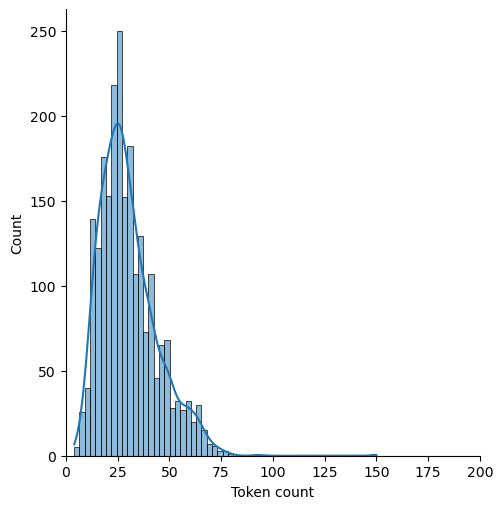

In [13]:
sns.displot(token_lens, kde=True)
plt.xlim([0,200])
plt.xlabel('Token count')
plt.show()

Most reviews have a token count less than 100 with an outlier at ~150. We'll choose our max length to be 150 in this case.

In [14]:
max_len = 150

#### Create PyTorch Dataset

In [15]:
# Pytorch dataset class/functions imported from Torch
class GPReviewDataset(Dataset):
  def __init__(self, articles, targets, tokenizer, max_len):
    self.articles = articles
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.articles)
  def __getitem__(self, item):
    article = str(self.articles[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      article,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'article_text': article,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

#### Train/Test Split

In [16]:
# Training set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

# Validation set
df_val, df_test = train_test_split(df, test_size=0.5, random_state=0)

#### Create Data Loaders

In [17]:
batch_size = 16

# Data loader function
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    articles=df['News Article'].to_numpy(),
    targets=df['Sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)

## BERT: Sequence Classification

In [21]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [25]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertForSequenceClassification.from_pretrained('bert-base_uncased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [24]:
class_names = [0, 1, 2]

model = SentimentClassifier(len(class_names))
model = model.to(device)

OSError: bert-base_uncased is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.